In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from math import pi
import itertools
from glob import glob

from scipy.optimize import curve_fit
import scipy.stats as ss
from sklearn.metrics import confusion_matrix

import pydicom

from bokeh.io import output_notebook, show
from bokeh.palettes import Category20c
from bokeh.palettes import Spectral4
from bokeh.plotting import figure
from bokeh.transform import cumsum
from bokeh.models import ColumnDataSource, HoverTool, Panel
from bokeh.models import Band

import matplotlib.pyplot as plt
import seaborn as sns

import albumentations as A

In [2]:
TEST_PATH = '../input/osic-pulmonary-fibrosis-progression/test/'
TRAIN_PATH = '../input/osic-pulmonary-fibrosis-progression/train/'
TEST_CSV_PATH = '../input/osic-pulmonary-fibrosis-progression/test.csv'
TRAIN_CSV_PATH = '../input/osic-pulmonary-fibrosis-progression/train.csv'

# Pulmonary Fibrosis Progression EDA

Better understading the prognosis of [pulmonary fibrosis](https://en.wikipedia.org/wiki/Pulmonary_fibrosis) disease could not only help the patients and their families, but also positively impact treatment trial design and accelerate the clinical development of novel treatments.

## Overview of the CSV Datasets

First of all let's overview the patients information: number of patients, gender, smoking status and age.

In [3]:
train_df = pd.read_csv(TRAIN_CSV_PATH)
test_df = pd.read_csv(TEST_CSV_PATH)

train_df.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
# See the example of pie chart implementation in bokeh:
# https://docs.bokeh.org/en/latest/docs/gallery/pie_chart.html?highlight=pie%20chart
def plot_pie_chart(data_dict, varname, title=''):
    """Plots the pie chart of the data in the dictionary."""

    data = pd.Series(data_dict).reset_index(name='value').rename(columns={'index': varname})
    data['angle'] = data['value']/data['value'].sum() * 2*pi
    data['color'] = Category20c[max(3,len(data_dict))][:len(data_dict)]

    p = figure(plot_height=350, title=title, toolbar_location=None,
            tools="hover", tooltips="@{}: @value".format(varname))

    p.wedge(x=0, y=1, radius=0.4,
            start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
            line_color="white", fill_color='color', source=data, legend_field=varname)

    output_notebook()
    show(p)

In [5]:
plot_pie_chart({'train (records)':len(train_df), 'test (records)':len(test_df)}, 'datasets', title='Train vs Test dataset size')

Loading BokehJS ...

In [6]:
plot_pie_chart({'train (patients)':train_df.Patient.nunique(), 'test (patients)':test_df.Patient.nunique()}, 'datasets', title='Number of unique patients')

Loading BokehJS ...

In [7]:
patient_df = train_df[['Patient', 'Sex', 'SmokingStatus', 'Age']].drop_duplicates()
male = patient_df[patient_df.Sex == 'Male'].shape[0]
female = patient_df[patient_df.Sex == 'Female'].shape[0]

plot_pie_chart({'male':male, 'female':female}, 'gender', title='Gender in Train Set')

Loading BokehJS ...

In [8]:
exsmoker = patient_df[patient_df.SmokingStatus == 'Ex-smoker'].shape[0]
neversmoker = patient_df[patient_df.SmokingStatus == 'Never smoked'].shape[0]
cursmoker = patient_df[patient_df.SmokingStatus == 'Currently smokes'].shape[0]

plot_pie_chart({'Ex-smoker':exsmoker, 'Never smoked':neversmoker, 'Currently smokes':cursmoker}, 'SmokingStatus', title='Smoking Status in Train set')

Loading BokehJS ...

In [9]:
# See this article on how to plot bar charts with Bokeh:
# https://towardsdatascience.com/interactive-histograms-with-bokeh-202b522265f3
def hist_hover(dataframe, column, colors=["#94c8d8", "#ea5e51"], bins=30, title=''):
    hist, edges = np.histogram(dataframe[column], bins = bins)
    
    hist_df = pd.DataFrame({column: hist,
                             "left": edges[:-1],
                             "right": edges[1:]})
    hist_df["interval"] = ["%d to %d" % (left, right) for left, 
                           right in zip(hist_df["left"], hist_df["right"])]

    src = ColumnDataSource(hist_df)
    plot = figure(plot_height = 400, plot_width = 600,
          title = title,
          x_axis_label = column,
          y_axis_label = "Count")    
    plot.quad(bottom = 0, top = column,left = "left", 
        right = "right", source = src, fill_color = colors[0], 
        line_color = "#35838d", fill_alpha = 0.7,
        hover_fill_alpha = 0.7, hover_fill_color = colors[1])
        
    hover = HoverTool(tooltips = [('Interval', '@interval'),
                              ('Count', str("@" + column))])
    plot.add_tools(hover)
    
    output_notebook()
    show(plot)

In [10]:
hist_hover(patient_df, 'Age', colors=["#94c8d8", "#ea5e51"], bins=30, title='Distribution of Age in train dataset')

Loading BokehJS ...

Some quick conclusions:
* We have 176 patiens in the train dataset with 1549 observations in total;
* Most of the patients are male;
* Most of the patients are ex-smokers;
* Most of the patients are between 60 and 80 years old;

Now let's look at FVC progressions. Plot FVC curves for random patients from the train set (you can use the interactive tools of the charts to explore):

In [11]:
# Example of a line chart in bokeh:
# https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html
def plot_FVC(data, patient_ids):
    p = figure(plot_width=800, plot_height=300)
    p.title.text = 'FVC progression'

    for patient_id, color in zip(patient_ids, Spectral4):
        df = data[data.Patient == patient_id].sort_values(by=['Weeks'], ascending=True)
        p.line(df['Weeks'], df['FVC'], line_width=2, color=color, alpha=0.9, legend_label='{}'.format(patient_id))
        s1 = p.scatter(df['Weeks'], df['FVC'], marker="circle", size=7,
              line_color=color, fill_color=color, alpha=1)
        p.add_tools(HoverTool(renderers=[s1], tooltips={"Week":"$x", "FVC":"$y"}))

    p.legend.location = "center_right"
    p.legend.click_policy="hide"

    output_notebook()

    show(p)

In [12]:
patient_ids_rnd = [patient_df.iloc[np.random.randint(len(patient_df))].Patient for i in range(3)]

plot_FVC(train_df, patient_ids_rnd)

Loading BokehJS ...

As we see, the FVC usually decreases through time. But the firts few observations of FVC usually don't show any trend (it looks like they just oscillate).

Let's plot the distribution of the FVC for each week:

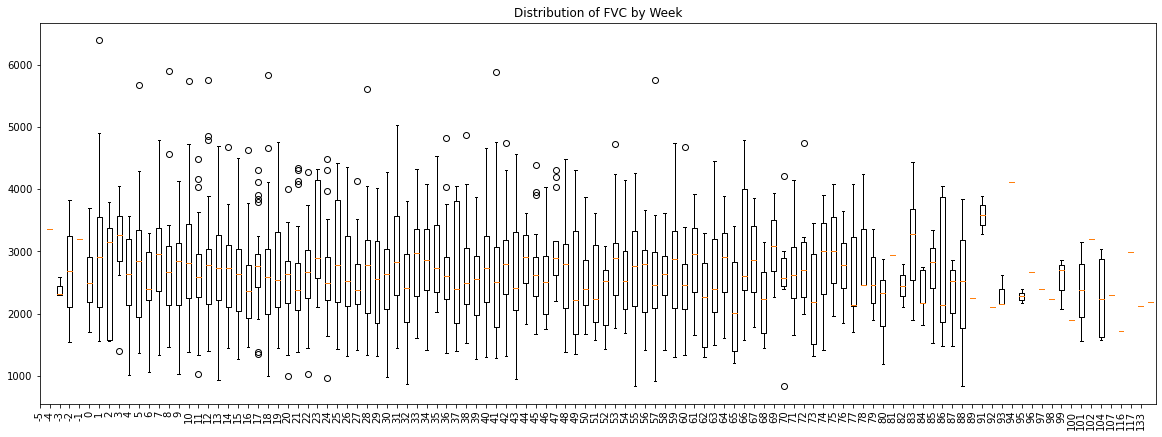

In [13]:
plt.figure(figsize=(20,7))

weekly_df = train_df.pivot(columns='Weeks', values='FVC')
weeks = weekly_df.columns.values

data = []
for col in weeks:
    x = weekly_df[col].values
    x = x[~np.isnan(x)]
    data.append(x)
    
plt.boxplot(data)
plt.title('Distribution of FVC by Week')

plt.xticks(range(len(weeks)), weeks, rotation=90)

plt.show()

It looks like in general the FVC just oscillates around some value over the weeks. We should consider different factors to predict the FVC.

Let's try to fit a simple exponential model to our data:

In [52]:
def exp_func(x, a, c, d):
    """Exponential function."""
    return a*np.exp(-c*x)+d

def linear_func(x, a, b):
    """Linear function."""
    return a*x+b

def fit_exp_curve(x, y):
    """Fit the exponential curve to the data."""
    popt, pcov = curve_fit(exp_func, x, y, p0=(1, 1e-6, 1))
    
    return popt

def fit_linear_curve(x, y):
    """Fit the linear curve to the data."""
    popt, pcov = curve_fit(linear_func, x, y, p0=(1, 1))
    
    return popt

def fit_curve_fvc(data, patient_id, function='exp'):
    """Fit the exponential curve to the patient's data."""
    x = data[data.Patient == patient_id].sort_values(by=['Weeks'], ascending=True).Weeks
    y = data[data.Patient == patient_id].sort_values(by=['Weeks'], ascending=True).FVC
    
    if function == 'exp':
        popt = fit_exp_curve(x, y)
    elif function == 'linear':
        popt = fit_linear_curve(x, y)
    else:
        raise ValueError('function should be one of: linear, exp')
    
    return popt

def get_prediction_interval(y, yhat):
    """Compute the prediction interval.
    
    Read more: https://machinelearningmastery.com/prediction-intervals-for-machine-learning/s
    """
    sum_errs = np.sum((y - yhat)**2)
    stdev = np.sqrt(1/(len(y)-2) * sum_errs)
    
    interval = 1.96 * stdev # 1.96 stdev contains 95% of values
    lower, upper = yhat - interval, yhat + interval
    
    return lower, upper, interval

def plot_curve(data, patient_id):
    """Plot patient's FVC and the fitted curve."""
    p = figure(plot_width=800, plot_height=300)
    p.title.text = 'FVC progression for {}'.format(patient_id)

    df = data[data.Patient == patient_id].sort_values(by=['Weeks'], ascending=True)
    p.line(df['Weeks'], df['FVC'], line_width=2, color="#94c8d8", alpha=0.9, legend_label='FVC')
    s1 = p.scatter(df['Weeks'], df['FVC'], marker="circle", size=7,
          line_color="#94c8d8", fill_color="#94c8d8", alpha=1)
    p.add_tools(HoverTool(renderers=[s1], tooltips={"Week":"$x", "FVC":"$y"}))
    
    # plot fitted exponential curve
    popt = fit_curve_fvc(data, patient_id)
    x = np.linspace(0, 80, 100)
    y = [exp_func(x, popt[0], popt[1], popt[2]) for x in np.linspace(0, 80, 100)]
    p.line(x, y, line_width=2, color="#ea5e51", alpha=0.9, legend_label='exponential curve', line_dash='dashed')
    
    # plot fitted linear curve
    popt = fit_curve_fvc(data, patient_id, function='linear')
    x = np.linspace(0, 80, 100)
    y = [linear_func(x, popt[0], popt[1]) for x in np.linspace(0, 80, 100)]
    p.line(x, y, line_width=2, color='#b35da6', alpha=0.9, legend_label='linear curve, a={:0.2f}, b={:0.2f}'.format(popt[0], popt[1]), line_dash='dashed')

    # get the prediction interval
    x = data[data.Patient == patient_id].sort_values(by=['Weeks'], ascending=True).Weeks
    y_true = data[data.Patient == patient_id].sort_values(by=['Weeks'], ascending=True).FVC
    yhat = [linear_func(xi, popt[0], popt[1]) for xi in x]
    
    lower, upper, interval = get_prediction_interval(y_true, yhat)
    
    source = ColumnDataSource({
        'base': np.linspace(0, 80, 100),
        'lower':[linear_func(x, popt[0], popt[1])-interval for x in np.linspace(0, 80, 100)],
        'upper':[linear_func(x, popt[0], popt[1])+interval for x in np.linspace(0, 80, 100)],
        })
    band = Band(base='base', lower='lower', upper='upper', level='underlay', source=source,
            fill_alpha=0.5, line_width=1, line_color=None)
    p.add_layout(band)
    
    p.legend.location = "bottom_left"
    p.legend.click_policy="hide"

    output_notebook()

    show(p)

In [53]:
plot_curve(train_df, 'ID00030637202181211009029')

Loading BokehJS ...

In [16]:
plot_curve(train_df, 'ID00305637202281772703145')

Loading BokehJS ...

In [17]:
plot_curve(train_df, 'ID00027637202179689871102')

Loading BokehJS ...

Now let's try to fit the curves and look how age/gender/smoking status is related to the fitted curve parameters.

In [18]:
# fit exponential curves to all patient's records
params_df = pd.DataFrame()
# loop through unique patients
for i, row in patient_df.iterrows():
    try:
        # fit curve to the patient's records
        exp_a, exp_c, exp_d =  fit_curve_fvc(train_df, row.Patient)
        lin_a, lin_b =  fit_curve_fvc(train_df, row.Patient, function='linear')
    except:
        # curve fitting failed
        continue
    # add the params to the dataframe
    params_df = params_df.append(
    {
        'Patient': row.Patient,
        'Age': row.Age,
        'Sex': row.Sex,
        'SmokingStatus': row.SmokingStatus,
        'exp_a': exp_a,
        'exp_c': exp_c,
        'exp_d': exp_d,
        'lin_a': lin_a,
        'lin_b': lin_b,
    }, ignore_index = True)

Let's explore the correlations between patient's age/gender/smoking status and the parameters of the fitted curve.

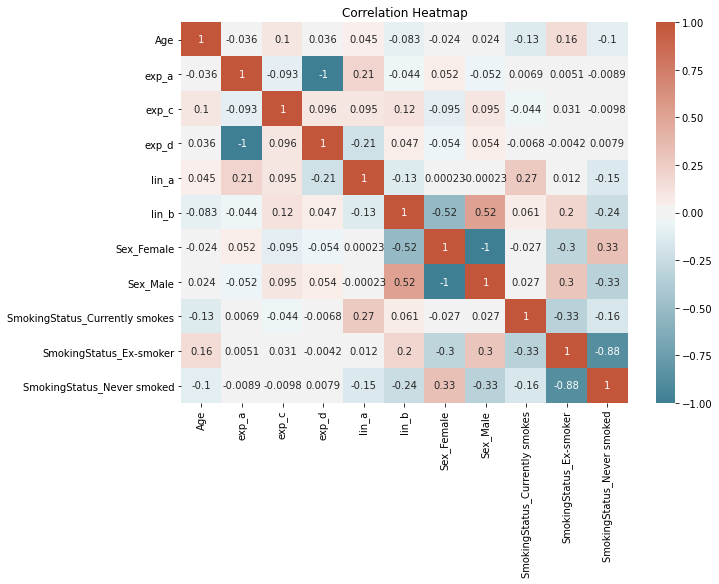

In [19]:
params_dummies_df = pd.get_dummies(params_df[['Age', 'Sex', 'SmokingStatus', 'exp_a', 'exp_c', 'exp_d', 'lin_a', 'lin_b']])
corr_df = params_dummies_df.corr()

fig = plt.figure(figsize=(10,7))
sns.heatmap(corr_df, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.title('Correlation Heatmap')
plt.show()

Quick conclusions:
* Coefficients of the linear model have some correlation with other patient's features, the exponential model coefficients don't have any correlation with other features at all. Does it mean that linear model is better? I don't think that linear model has to be better, because correlation only reflects linear relationships.
* The slope (lin_a) of the linear model has slight positive correlation with SmokingStatus_CurrentlySmokes. Current smokers have higher slope coefficients. Could it mean that FVC declines faster for non-smikong people? :)
* The intercept (lin_b) has somewhat correlation with gender. It doesn't mean that FVC is higher for male patients, it just means that male patients may have larger lungs.
* The intercept has slight positive correlation with ex-smoker status and slight negative correlation with never smoked status. 

In general, it makes sense to add age, gender and smoking status to the final model.

## Overview of the Images

Let's look at some images:

In [20]:
# get the paths to the images from train dataset
train_fns = glob(TRAIN_PATH+'/*/*')

def plot_images(train_data, n_rows=3, n_cols=3):
    ids = np.random.randint(0, len(train_fns), n_rows*n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    
    for i in range(n_rows):
        for j in range(n_cols):
            filename = train_fns[ids[i*n_cols + j]]
            idx = filename.split('/')[-2]
            
            data = train_data[(train_data.Patient == idx)]
            age = data.Age.values[0]
            gender = data.Sex.values[0]
            fvc = None
            data = train_data[(train_data.Patient == idx) & (train_data.Weeks == 0)]
            if len(data) > 0:
                fvc = data.FVC.values[0]
            
            img = pydicom.read_file(filename).pixel_array
            axs[i,j].imshow(img, cmap='bone')
            axs[i,j].axis('off')
            if fvc:
                axs[i,j].set_title('{}, age {} \n FVC {}'.format(gender, age, fvc))
            else:
                axs[i,j].set_title('{}, age {}'.format(gender, age))
     
    plt.suptitle('CTs')
    plt.show()

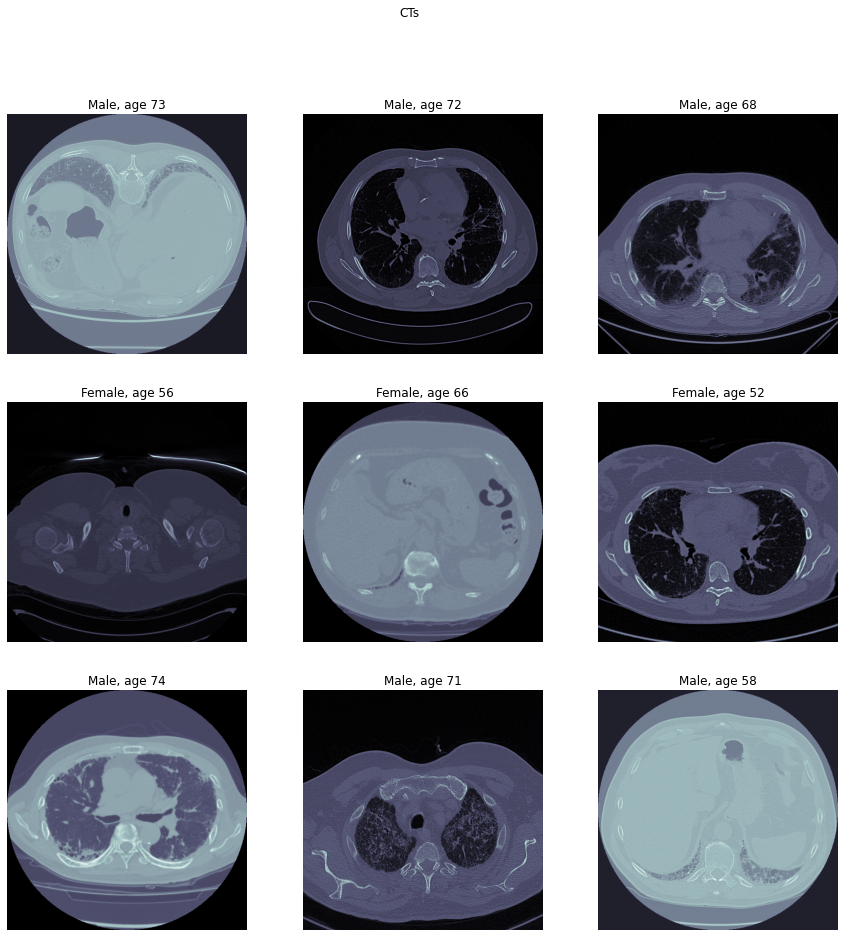

In [21]:
plot_images(train_df)

FVC images all have same sizes (512 X 512), but they all have different intensities, so using some filters like CLAHE will be very helpful.

Let's compare the brightests and the darkest images:

In [22]:
def get_brightness(filename):
    """Open the file and return the average brightness of the pixels."""
    img = pydicom.read_file(filename).pixel_array
    # return the average intensity of the pixels
    return np.mean(np.where(img>0, img,0))

def generate_brightness_df(train_data):
    """Generates pandas dataframe with average brightness for each image."""
    brightness_df = pd.DataFrame()
    
    for fname in train_fns:
        try:
            brightness = get_brightness(fname)
            idx = fname.split('/')[-2]

            brightness_df = brightness_df.append(
            {
                'Patient':idx,
                'Fname':fname,
                'Brightness':brightness,
            },
            ignore_index=True)
        except:
            continue
        
    return brightness_df

def plot_top_bright(brighness_df, n_rows=3, n_cols=3, bright=True):
    """Plot top brightest/darkest images."""
    if bright:
        title = 'Top {} brightest images'.format(n_rows*n_cols)
        data = brighness_df.sort_values(by=['Brightness'], ascending=True)
    else:
        title = 'Top {} darkest images'.format(n_rows*n_cols)
        data = brighness_df.sort_values(by=['Brightness'], ascending=False)
        
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    
    for i in range(n_rows):
        for j in range(n_cols):
            
            row = data.iloc[i*n_cols+j]
            fname = row.Fname
            
            img = pydicom.read_file(fname).pixel_array
            
            axs[i,j].imshow(img, cmap='bone')
            axs[i,j].set_title(row.Patient)
            axs[i,j].axis('off')
            
    plt.suptitle(title)
    plt.show()

In [23]:
brightness_df = generate_brightness_df(train_df)

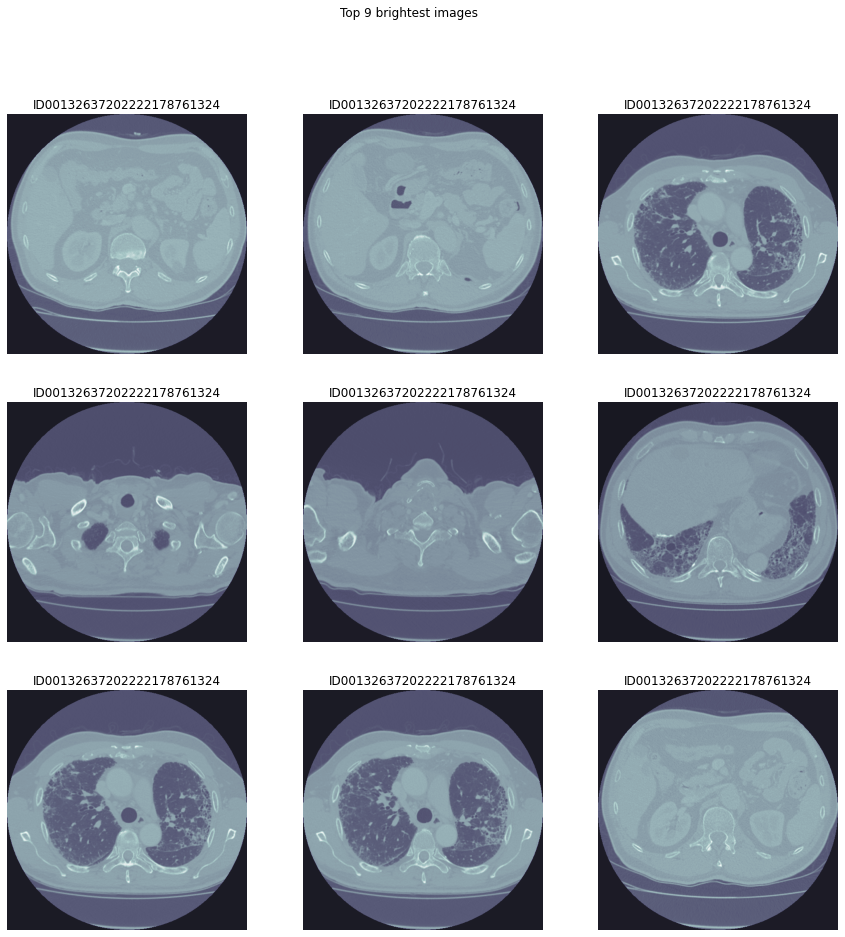

In [24]:
plot_top_bright(brightness_df)

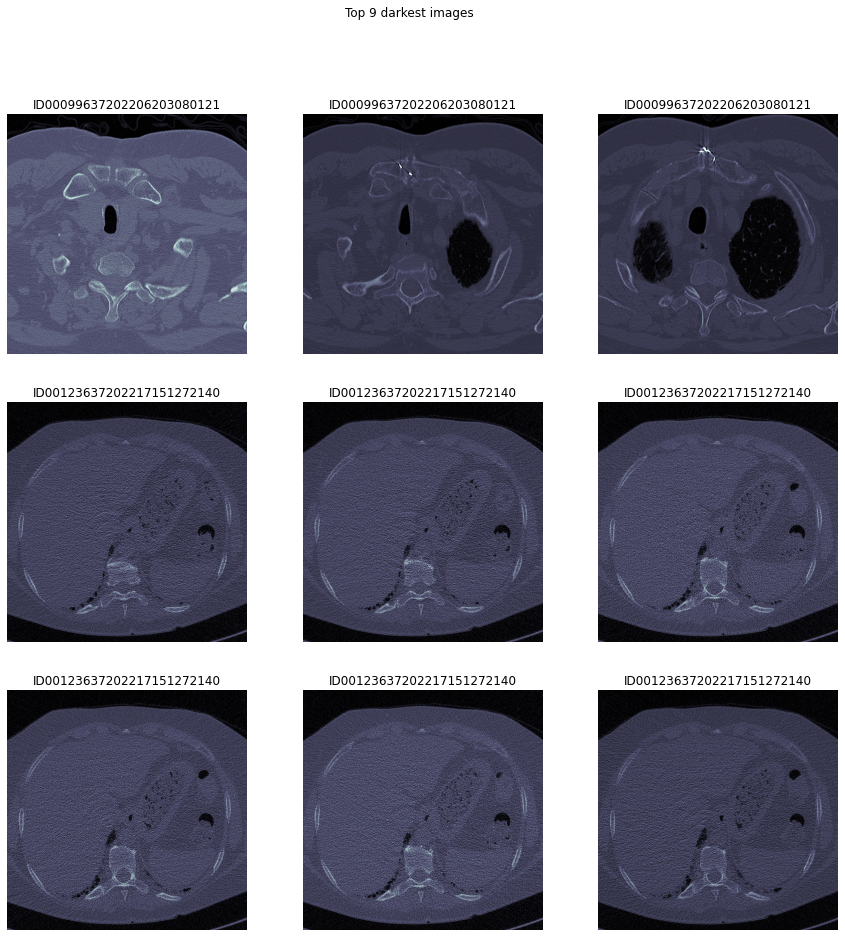

In [25]:
plot_top_bright(brightness_df, bright=False)

Let's try some augmentations:

In [26]:
# took an example of augmentation pipeline from here:
# https://github.com/albumentations-team/albumentations_examples/blob/master/notebooks/example.ipynb
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=.5),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
])

def visualize_augmentations(n_rows=3, n_cols=3):
    idx = np.random.randint(0, len(train_fns))
    fname = train_fns[idx]
    image = pydicom.read_file(fname).pixel_array
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    for i in range(n_rows):
        for j in range(n_cols):
            
            augmented_image = transform(image=image)['image']

            axs[i,j].imshow(augmented_image, cmap='bone')
            axs[i,j].axis('off')

    plt.suptitle('Examples of augmentations {}'.format(fname.split('/')[-2]))
    plt.show()

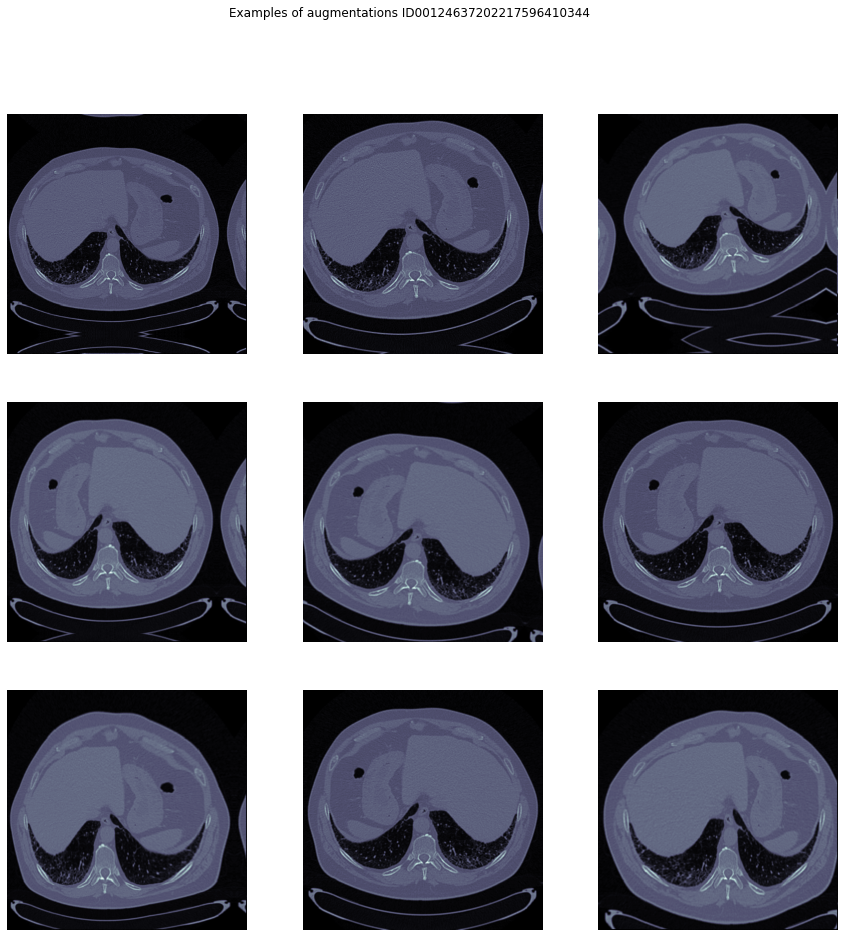

In [27]:
visualize_augmentations()

## Useful Links

1. [Challenges in pulmonary fibrosis](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2117220/). Article contains some examples of CT scans with pulmonary fibrosis.
2. [Previous Pneumothorax Segmentation competition](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation). This competition was also related to the lung images. Some image augmentation methods used in this competition may be applicable.
3. [Computer-Aided Diagnosis of Pulmonary Fibrosis Using Deep Learning and CT Images](https://journals.lww.com/investigativeradiology/FullText/2019/10000/Computer_Aided_Diagnosis_of_Pulmonary_Fibrosis.2.aspx). A related article. Could be very helpful here.

# Conclusions

In this analysis we:
* looked at the distributions of patients' features and FVC in the dataset;
* tried to apply curve fitting to find some relationships between the features (age, gender, smoking status) and the FVC trend;
* viewed some CT scans and applied little augmentations.